# Downstream analysis pySCENIC

Downstream analysis using the loom file generated from [this notebook]("./pySCENIC_NK_mm.ipynb")

In [173]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from pyscenic.utils import load_motifs
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

import warnings
warnings.filterwarnings('ignore')

In [125]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = "Results/mm_scenic_integrated-output.loom"

In [126]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)



## Extract relevant data from the integrated loom file


In [127]:


# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)



In [128]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)



In [154]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.new_label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.percent_mt, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.batch, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'new_label',
 'label',
 'percent_mt',
 'nGene',
 'nUMI',
 'batch']


In [ ]:
# capture embeddings:

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

dr = pd.DataFrame()
dr.index = drx.index
dr["X"] = drx
dr["Y"] = dry




In [ ]:
lf.close()

### Using anndata

In [ ]:
adata = sc.read( f_final_loom, validate=False)

# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )


In [ ]:
adata.obsm["X_umap"] = np.array(dr)

In [130]:
sc._utils.sanitize_anndata( adata )

In [131]:
# load the regulons from a file using the load_signatures function
sig = load_signatures('Results/reg_mm.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


### UMAP and knn graph from auc_mtx

In [179]:
with open("Results/auc_mtx.csv") as your_data:
    adata_umap = anndata.read_csv(your_data)

adata_umap.obs["label"] = adata.obs["label"]
adata_umap.obs["new_label"] = adata.obs["new_label"]
adata_umap.obs["batch"] = adata.obs["batch"]

In [186]:
sc.tl.pca(adata_umap)
sc.pp.neighbors(adata_umap, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_umap)

In [187]:
adata_umap.var_names

Index(['ARID3A_(+)', 'ARNTL_(+)', 'ATF1_(+)', 'ATF2_(+)', 'ATF4_(+)',
       'ATF6_(+)', 'BACH1_(+)', 'BACH2_(+)', 'BCL11B_(+)', 'BCL6_(+)',
       ...
       'ZNF576_(+)', 'ZNF580_(+)', 'ZNF587_(+)', 'ZNF600_(+)', 'ZNF655_(+)',
       'ZNF669_(+)', 'ZNF680_(+)', 'ZNF708_(+)', 'ZNF770_(+)', 'ZSCAN26_(+)'],
      dtype='object', length=219)

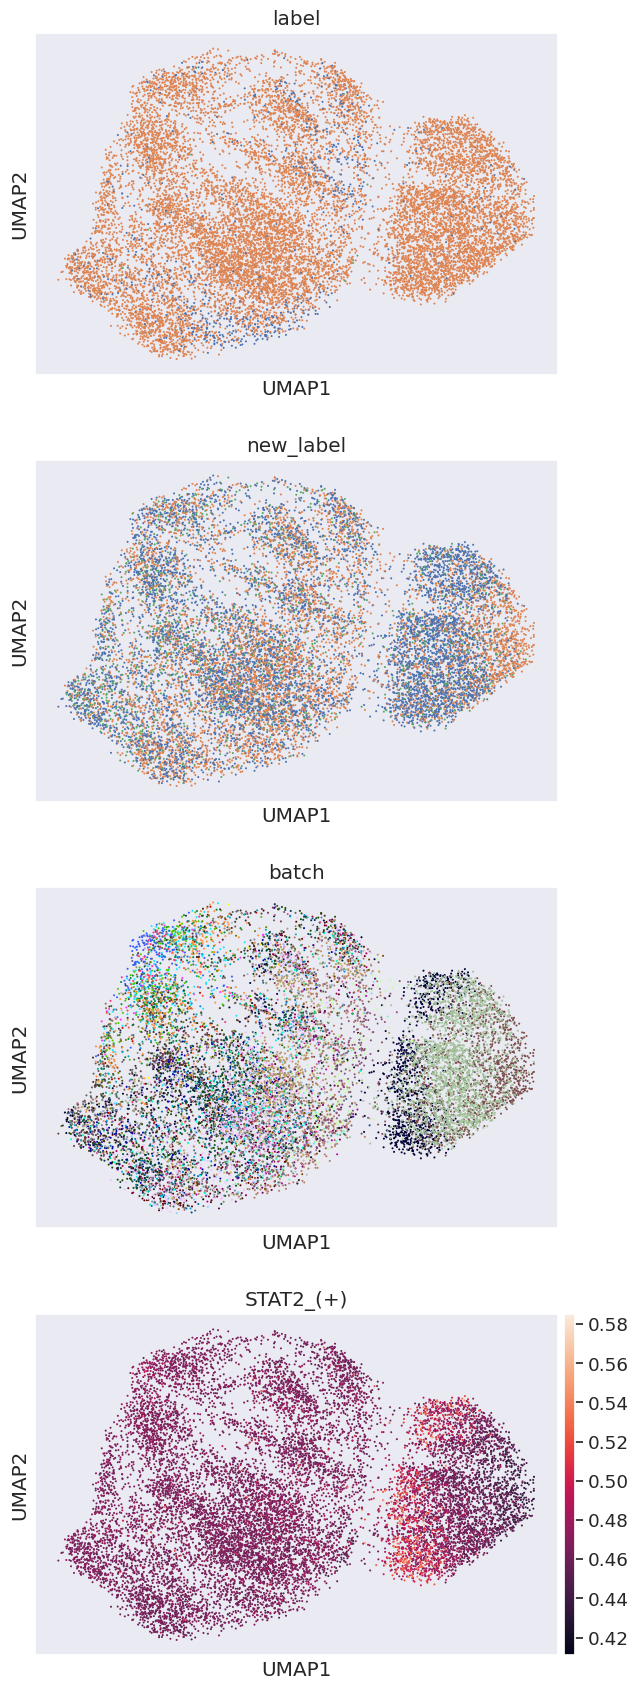

In [189]:
sc.pl.umap(adata_umap, color=["label","new_label","batch"], ncols=1, legend_loc=None)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


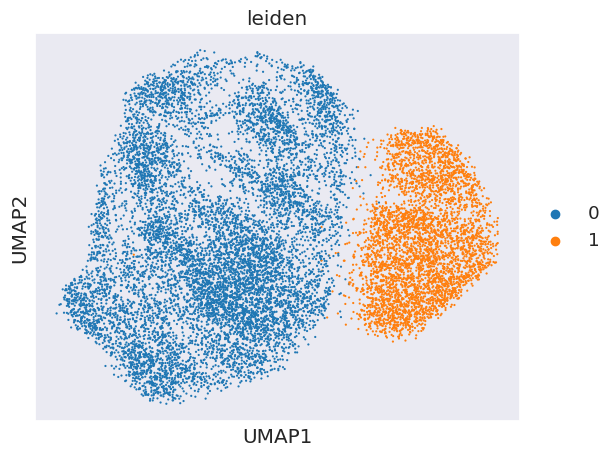

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


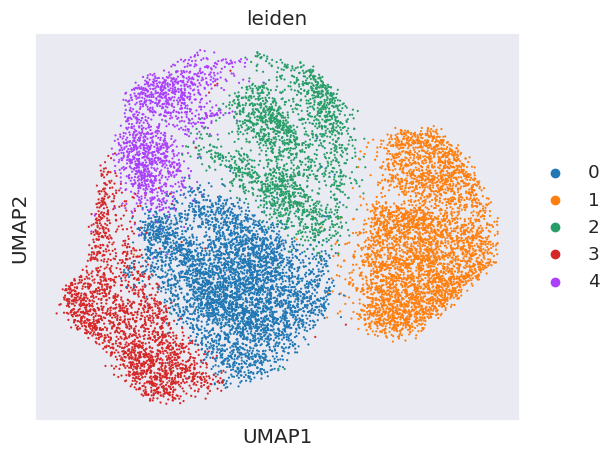

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


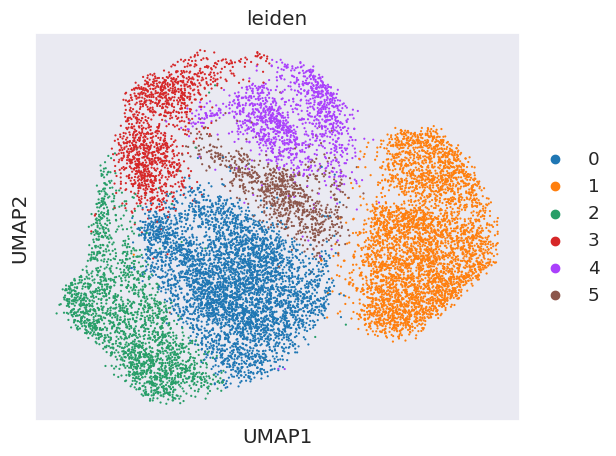

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


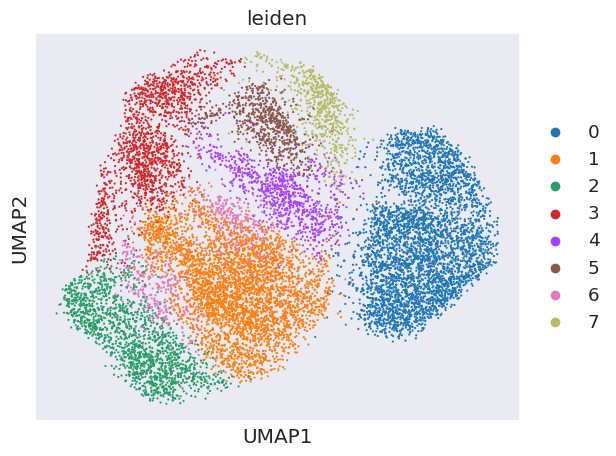

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


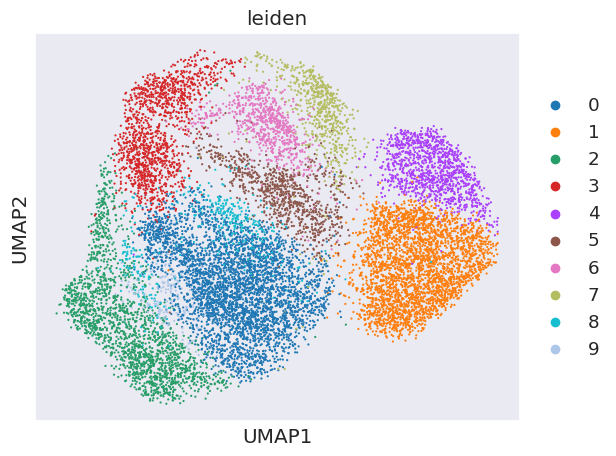

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


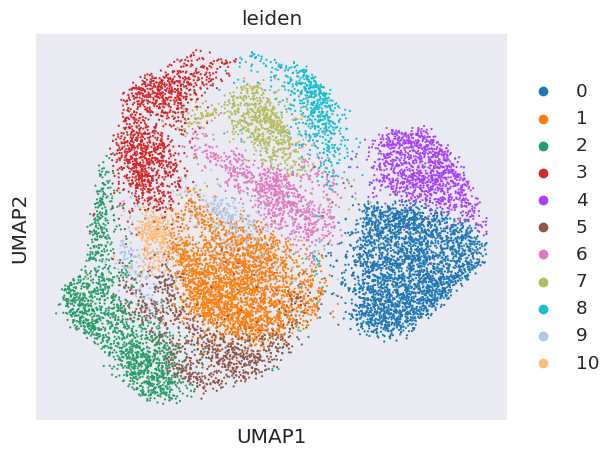

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


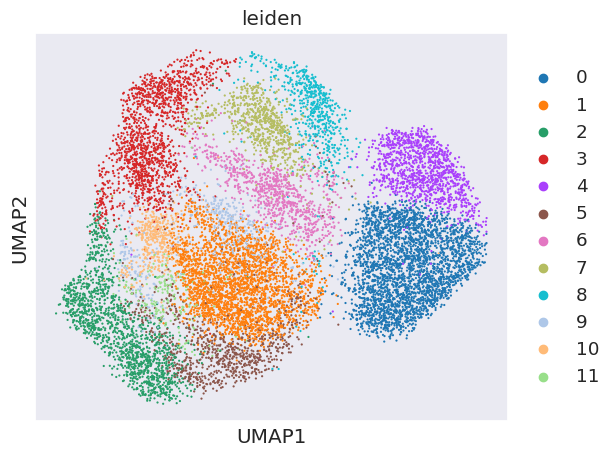

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


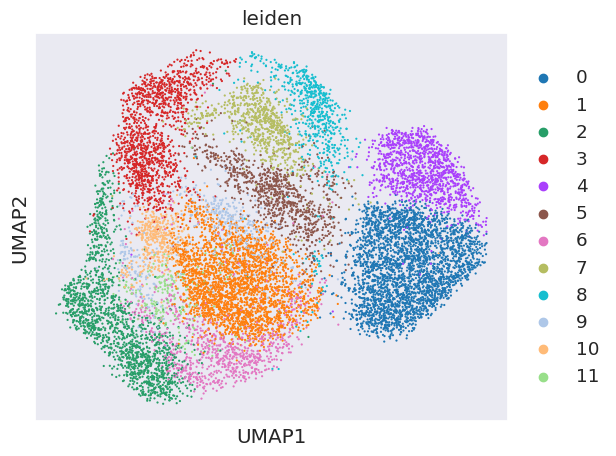

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


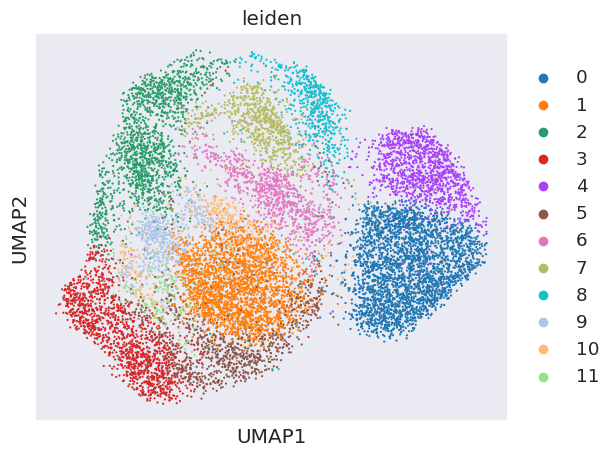

In [193]:
for n in range(1, 10):
    n = n/10
    sc.tl.leiden(adata_umap, resolution=n)
    sc.pl.umap(adata_umap, color="leiden", size=10)

In [197]:
sc.tl.leiden(adata_umap, resolution=0.1)
#sc.tl.rank_genes_groups(adata, groupby='leiden', method='logreg')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata_umap


running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


AnnData object with n_obs × n_vars = 14038 × 219
    obs: 'label', 'new_label', 'batch', 'leiden'
    uns: 'pca', 'batch_colors', 'label_colors', 'new_label_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Print top enriched TFs and motifs

In [132]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [133]:
df_motifs = load_motifs('Results/reg_mm.csv')

In [134]:
sorted_tfs = df_motifs.sort_values([("Enrichment","NES")], ascending=False).index.get_level_values('TF').to_list()

def get_unique_N(iterable, N):
    """Yields (in order) the first N unique elements of iterable. 
    Might yield less if data too short."""
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        if len(seen) == N:
            seen = list(seen)
            return seen

top_five = get_unique_N(sorted_tfs, 5)
top_five


['IRF2', 'IRF9', 'STAT2', 'IRF7', 'STAT1']

In [135]:
df_motifs_sel = df_motifs.iloc[ [ True if x in top_five else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [136]:
#display_logos(df_motifs.head())
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False))

## Regulon specificity scores (RSS) across predicted cell types

In [137]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['label'] )
rss_cellType

ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  \
CD56dimCD16+ NK cells       0.850005   0.848235  0.851382  0.850924  0.847210   
CD56brightCD16- NK cells    0.240429   0.238535  0.240312  0.239989  0.241538   
NK cell progenitors         0.170507   0.170515  0.170512  0.170446  0.170832   

                          ATF6_(+)  BACH1_(+)  BACH2_(+)  BCL11B_(+)  \
CD56dimCD16+ NK cells     0.847819   0.852369   0.848943    0.853502   
CD56brightCD16- NK cells  0.240799   0.239615   0.241268    0.237963   
NK cell progenitors       0.170670   0.170458   0.170381    0.170398   

                          BCL6_(+)  ...  ZNF576_(+)  ZNF580_(+)  ZNF587_(+)  \
CD56dimCD16+ NK cells     0.846625  ...    0.849734    0.850687    0.842426   
CD56brightCD16- NK cells  0.238064  ...    0.240118    0.240913    0.240623   
NK cell progenitors       0.170489  ...    0.170609    0.170712    0.170408   

                          ZNF600_(+)  ZNF655_(+)  ZNF669_(+)  ZNF680_(+)  \
CD56dimCD16+ NK cells       0.848558    0.845024    0.850005    0.846446   
CD56brightCD16- NK cells    0.238787    0.240957    0.240941    0.240025   
NK cell progenitors         0.170420    0.170640    0.170526    0.170437   

                          ZNF708_(+)  ZNF770_(+)  ZSCAN26_(+)  
CD56dimCD16+ NK cells       0.812869    0.842980     0.806803  
CD56brightCD16- NK cells    0.242565    0.240801     0.258789  
NK cell progenitors         0.170444    0.170371     0.170293  

[3 rows x 219 columns]

In [138]:
rss_cellType.iloc[0].sort_values(ascending=False)

KLF2_(+)       0.854055
BCL11B_(+)     0.853502
HOXB2_(+)      0.853414
PURA_(+)       0.853249
MECP2_(+)      0.853230
                 ...   
FOXN2_(+)      0.827098
HMGA1_(+)      0.826820
ZNF121_(+)     0.823741
ZNF708_(+)     0.812869
ZSCAN26_(+)    0.806803
Name: CD56dimCD16+ NK cells, Length: 219, dtype: float64

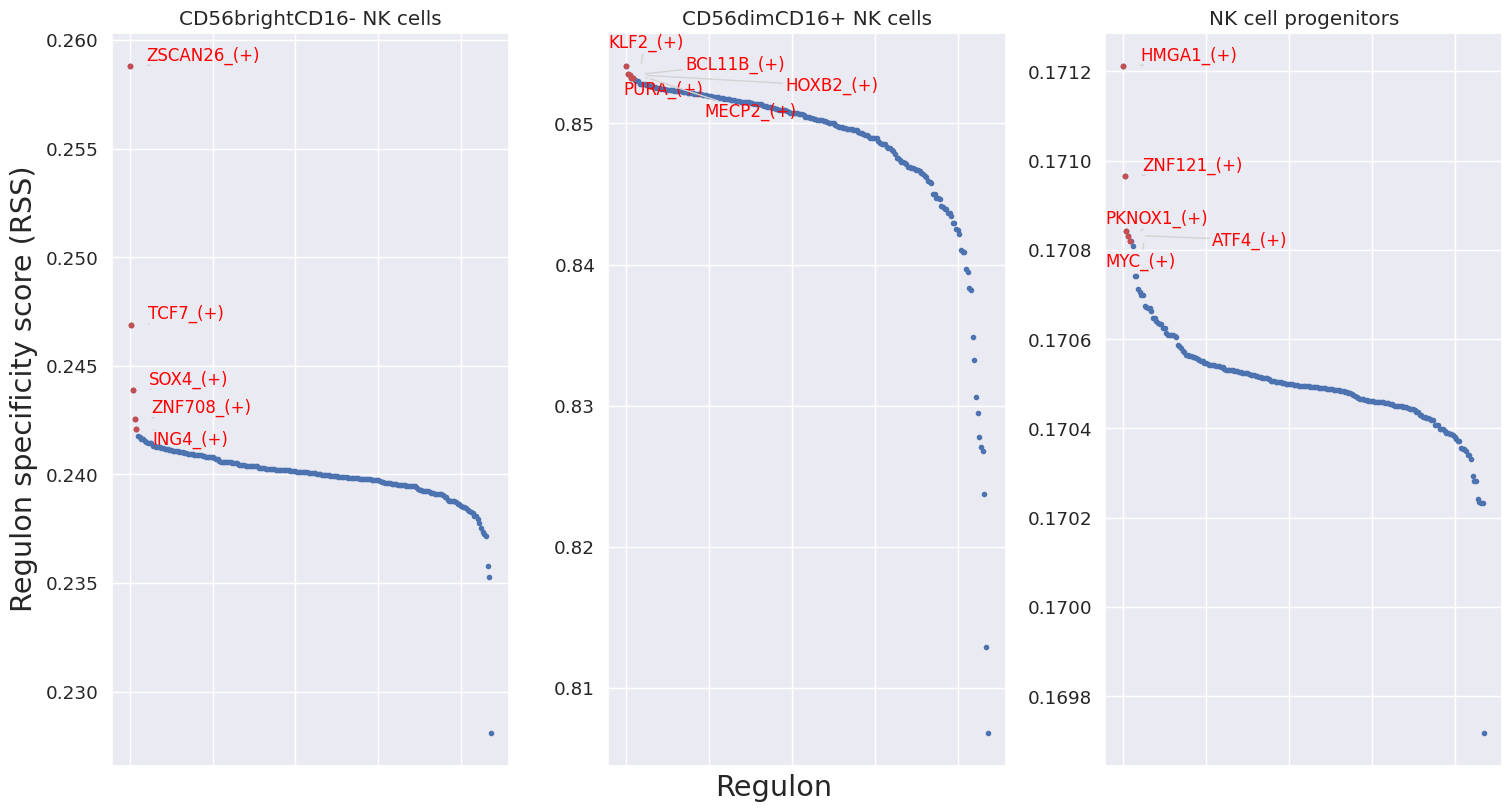

In [139]:
cats = sorted(list(set(cellAnnot['label'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [140]:
# top regulons for each cell type
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

topreg

['ING4_(+)',
 'TCF7_(+)',
 'MYC_(+)',
 'HOXB2_(+)',
 'ZNF121_(+)',
 'KLF2_(+)',
 'PURA_(+)',
 'ZNF708_(+)',
 'ZSCAN26_(+)',
 'ATF4_(+)',
 'HMGA1_(+)',
 'MECP2_(+)',
 'SOX4_(+)',
 'PKNOX1_(+)',
 'BCL11B_(+)']

In [141]:
# Z-score area under the curve for selected regulons
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)



In [142]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f



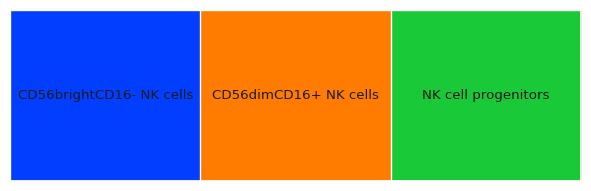

In [143]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['label'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=2.0)
plt.savefig("test-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

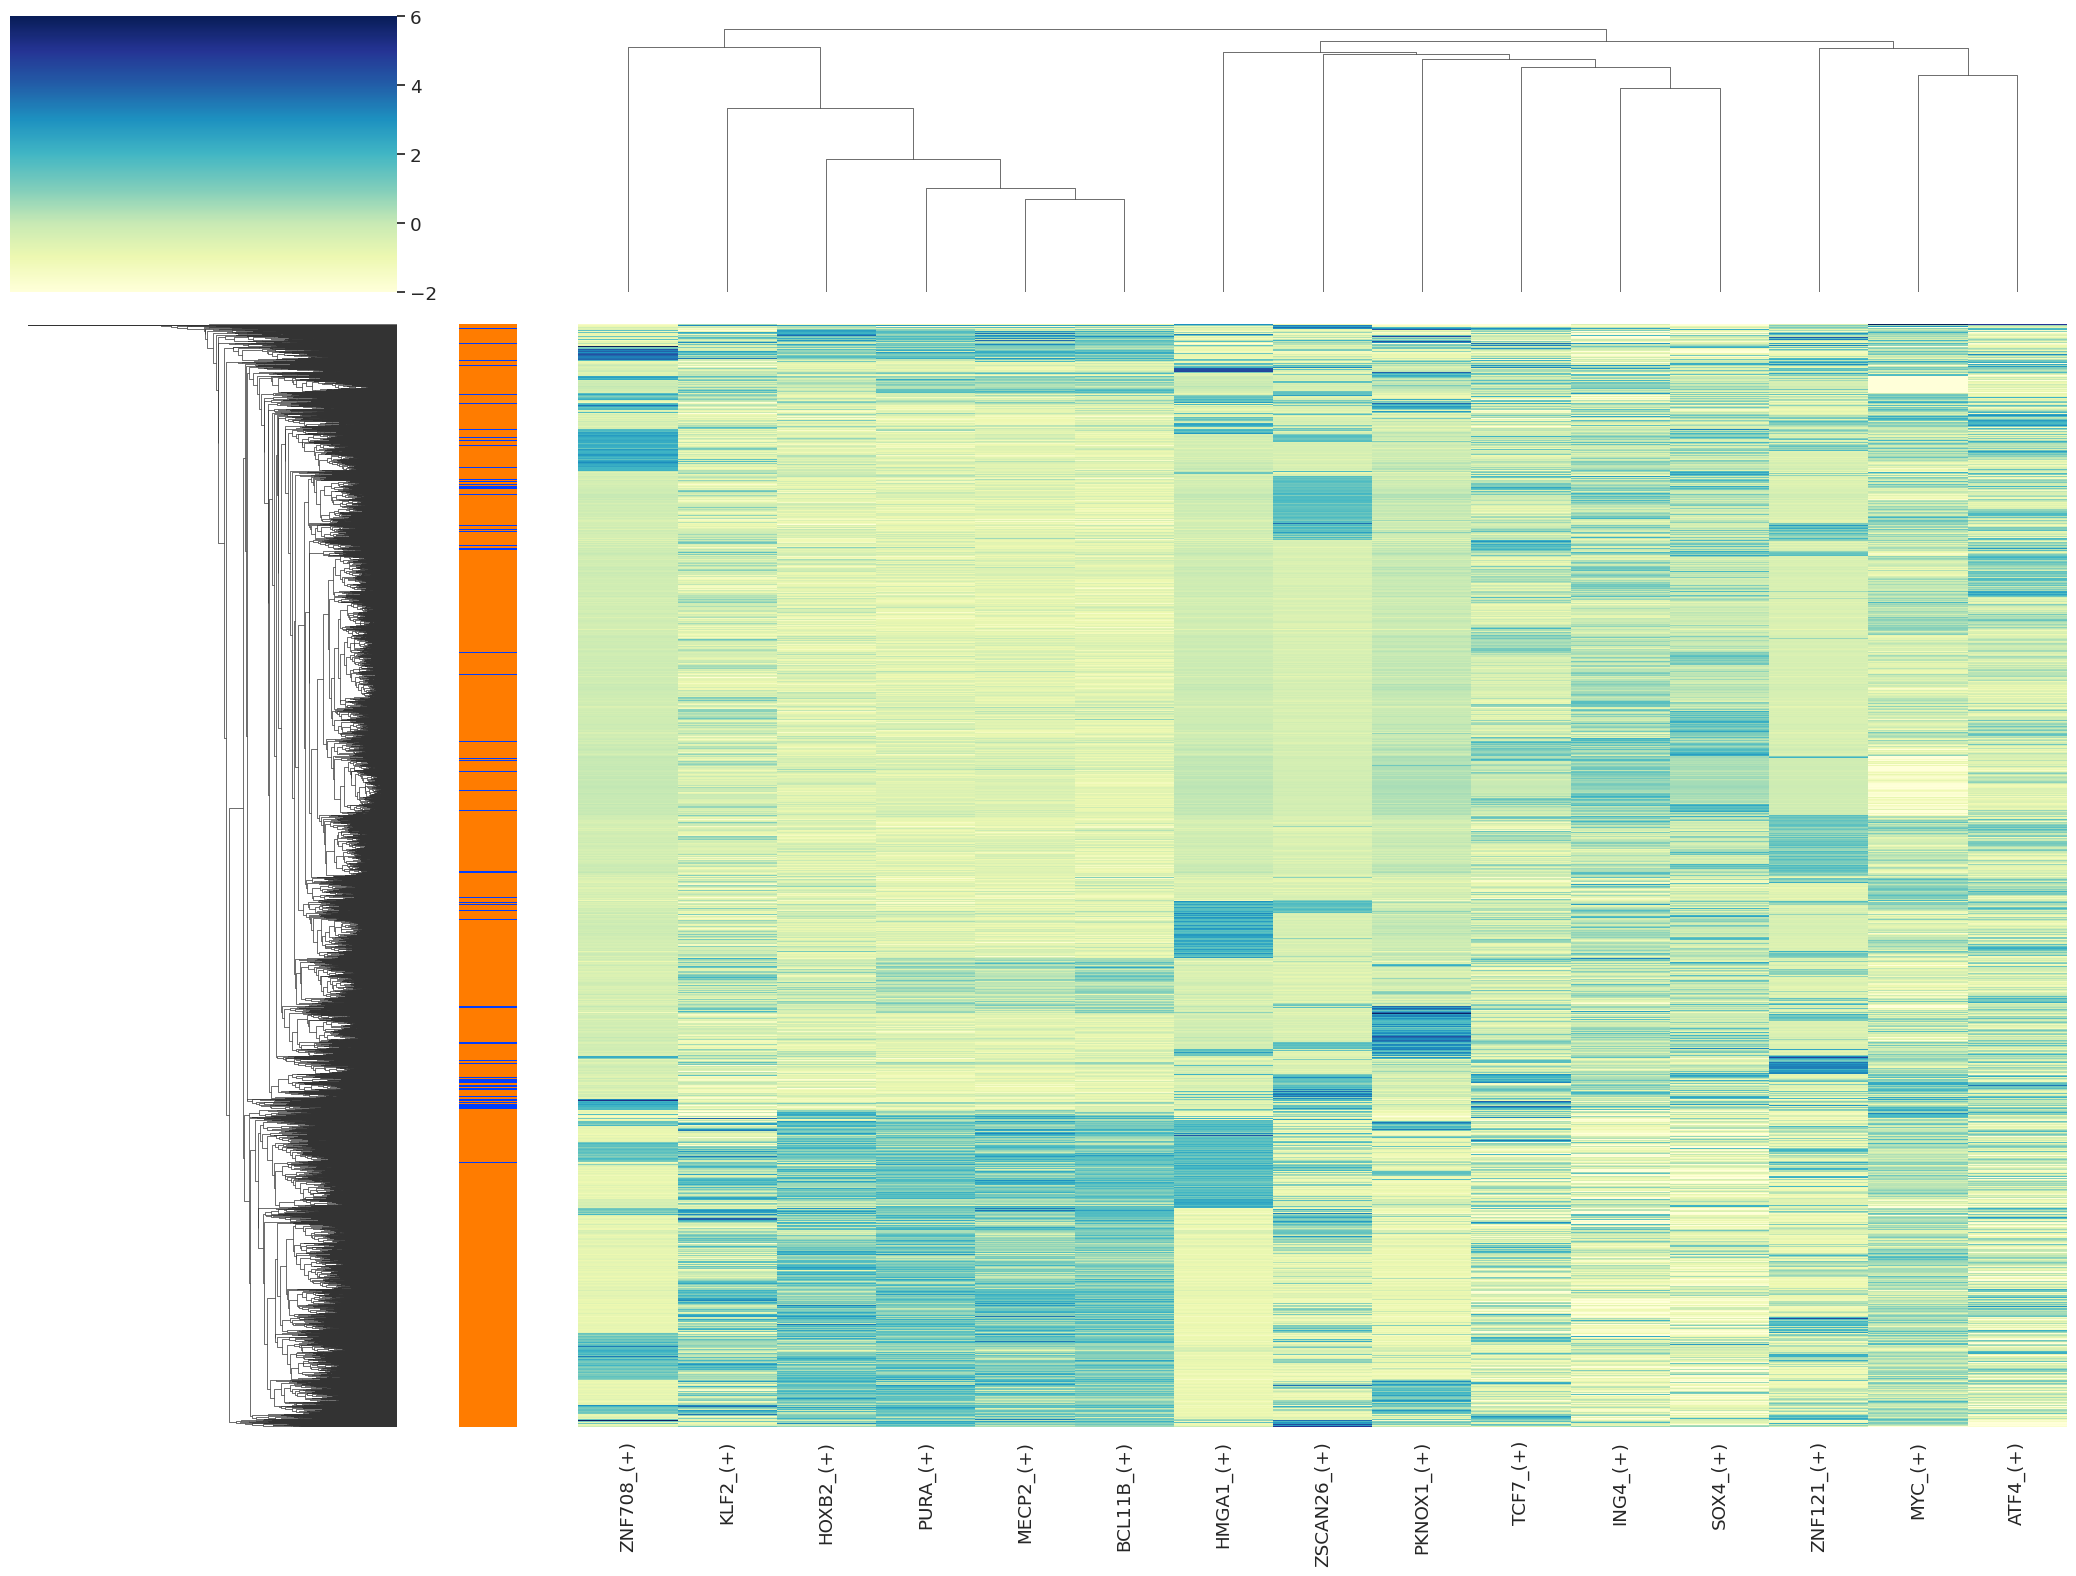

In [144]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("test-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [145]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.label.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

mean  StDev  Ratio
CD56dimCD16+ NK cells     0.849  0.006  0.938
CD56brightCD16- NK cells  0.240  0.002  0.060
NK cell progenitors       0.171  0.000  0.001

The specificity for the cell types looks odd, all the TF have a narrow range of specificity for each cell types, the scores resemble the different cell types ratios. Probably the RSS is biased by the big differences of proportions.


## Regulon specificity scores (RSS) across predicted cell state

In [146]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['new_label'] )
rss_cellType

ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  ATF6_(+)  \
NK exhausted    0.514180   0.512168  0.513665  0.513089  0.511467  0.511858   
Others          0.280291   0.278536  0.279930  0.279856  0.278547  0.280299   
NK resident     0.493159   0.494744  0.494433  0.494691  0.496657  0.494826   

              BACH1_(+)  BACH2_(+)  BCL11B_(+)  BCL6_(+)  ...  ZNF576_(+)  \
NK exhausted   0.512965   0.510115    0.515166  0.512999  ...    0.513230   
Others         0.279328   0.279817    0.278881  0.278929  ...    0.279952   
NK resident    0.495591   0.497573    0.493287  0.492692  ...    0.494112   

              ZNF580_(+)  ZNF587_(+)  ZNF600_(+)  ZNF655_(+)  ZNF669_(+)  \
NK exhausted    0.513042    0.511271    0.510530    0.511986    0.513497   
Others          0.279569    0.279801    0.279862    0.280485    0.279689   
NK resident     0.495401    0.493328    0.495688    0.493470    0.494551   

              ZNF680_(+)  ZNF708_(+)  ZNF770_(+)  ZSCAN26_(+)  
NK exhausted    0.512413    0.505299    0.510947     0.504432  
Others          0.280277    0.278941    0.280305     0.277005  
NK resident     0.493261    0.486796    0.493625     0.493955  

[3 rows x 219 columns]

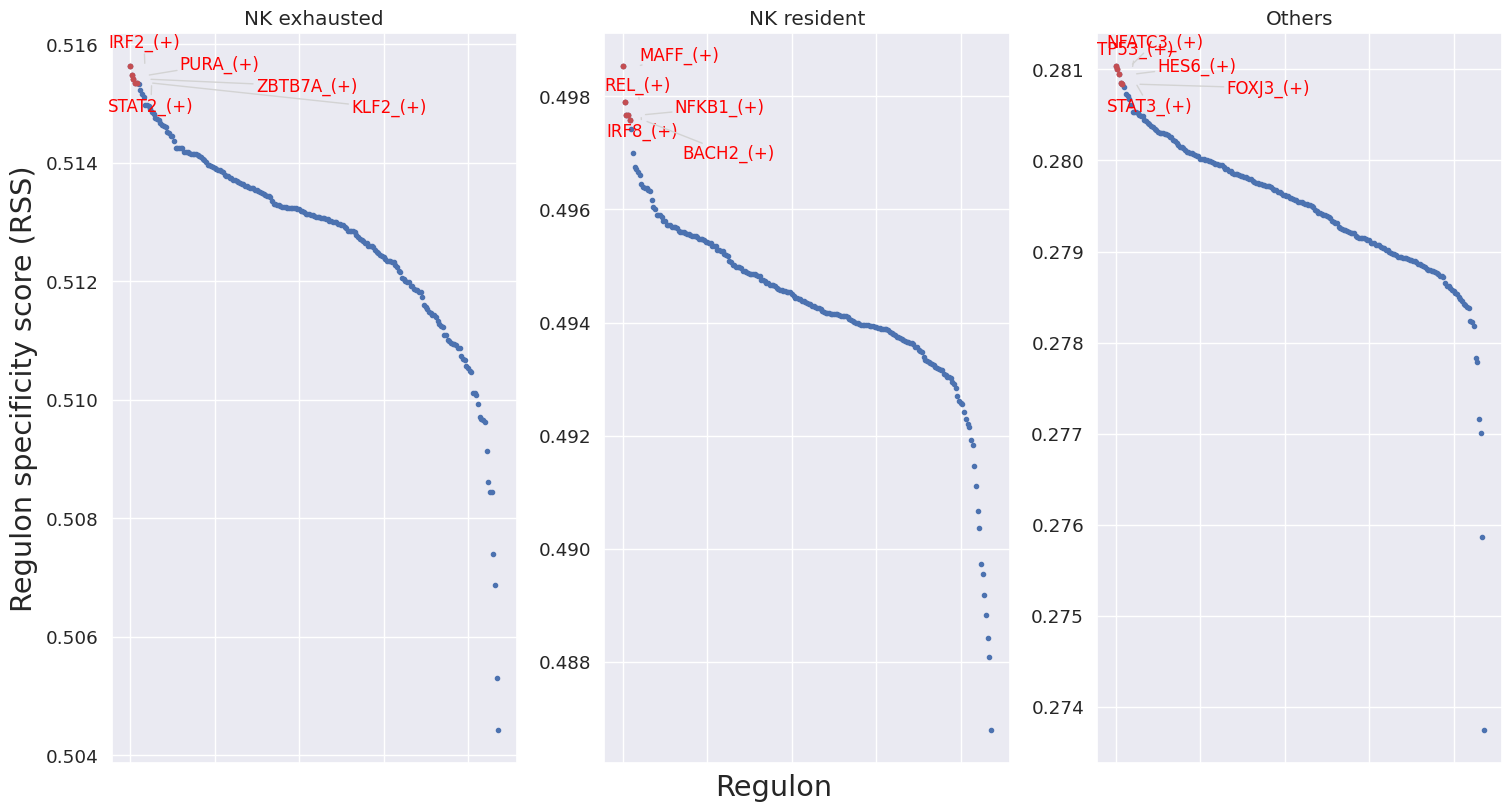

In [147]:
cats = sorted(list(set(cellAnnot['new_label'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [148]:
# top regulons for each cell type
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

topreg

['STAT3_(+)',
 'MAFF_(+)',
 'HES6_(+)',
 'TP53_(+)',
 'REL_(+)',
 'NFATC3_(+)',
 'PURA_(+)',
 'KLF2_(+)',
 'ZBTB7A_(+)',
 'STAT2_(+)',
 'FOXJ3_(+)',
 'IRF8_(+)',
 'IRF2_(+)',
 'NFKB1_(+)',
 'BACH2_(+)']

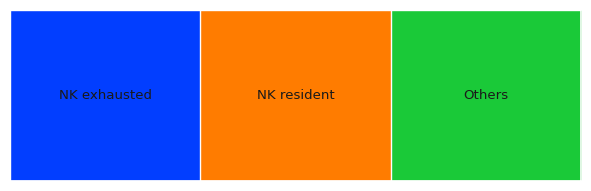

In [149]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['new_label'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=2.0)
plt.savefig("test-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

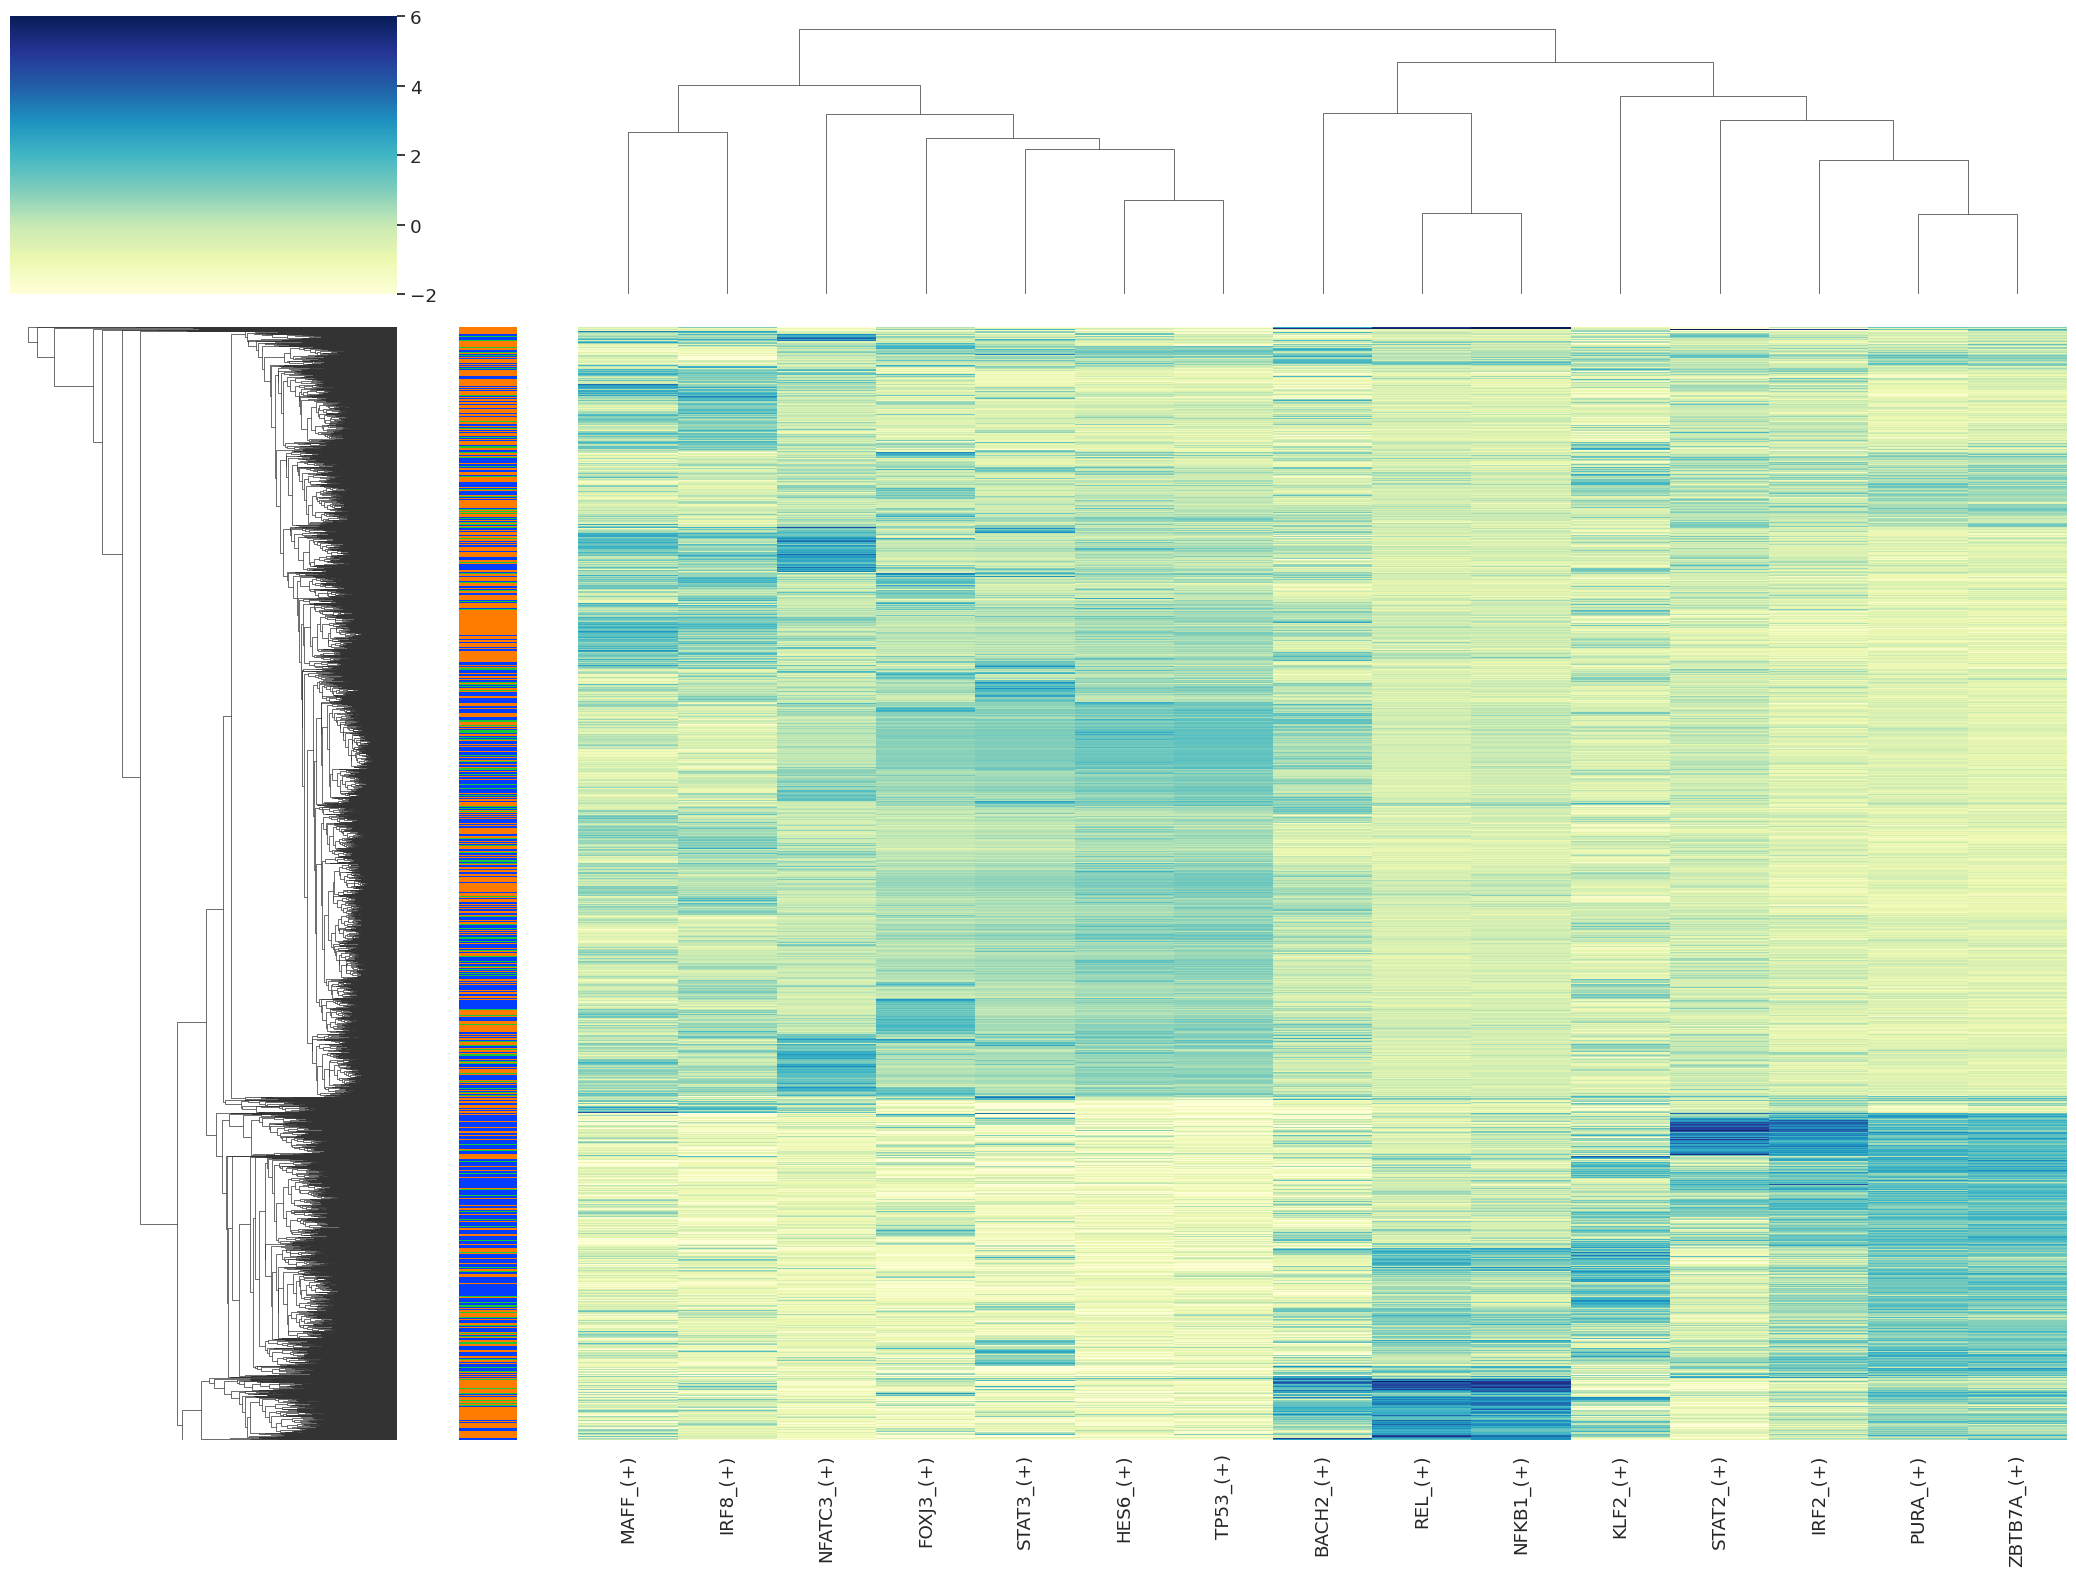

In [150]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("test-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [151]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.new_label.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs

mean  StDev  Ratio
NK exhausted  0.513  0.002  0.464
Others        0.279  0.001  0.105
NK resident   0.494  0.002  0.431

Similarly to the previous result, also the cell state RSS looks biased by cell type proportion. To evaluate the RSS for the cell types I am going to try to cluster the cells using the UMAP deriving from the TF activities and see if any cluster has immune checkpoint receptors as markers. Also, I am going to check if the activity is specific of the batch:

In [155]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['batch'] )
rss_cellType

ARID3A_(+)  ARNTL_(+)  ATF1_(+)  ATF2_(+)  ATF4_(+)  \
MGUS_CD138nCD45p_2    0.170213   0.169967  0.170155  0.170172  0.170108   
MGUS_CD138nCD45p_3    0.196614   0.194986  0.195827  0.196115  0.195782   
MGUS_CD138nCD45p_4    0.175335   0.174897  0.175127  0.175210  0.175178   
MGUS_CD138nCD45p_5    0.175017   0.174517  0.174799  0.174882  0.174855   
MGUS_CD138n_1         0.188847   0.187487  0.188278  0.188509  0.188095   
...                        ...        ...       ...       ...       ...   
SMM_CD138nCD45p_9     0.179693   0.178701  0.179380  0.179546  0.179137   
SMM_CD138n_3          0.170682   0.170368  0.170613  0.170668  0.170489   
SMM_CD138n_4          0.197817   0.195353  0.197119  0.197346  0.196790   
SMM_CD138n_5          0.172183   0.171770  0.172118  0.172185  0.171986   
SMM_CD138n_6          0.171976   0.171794  0.171846  0.171896  0.171757   

                    ATF6_(+)  BACH1_(+)  BACH2_(+)  BCL11B_(+)  BCL6_(+)  ...  \
MGUS_CD138nCD45p_2  0.170282   0.170086   0.170166    0.170014  0.170203  ...   
MGUS_CD138nCD45p_3  0.196671   0.195507   0.195413    0.194816  0.195225  ...   
MGUS_CD138nCD45p_4  0.175299   0.175018   0.175091    0.174866  0.174830  ...   
MGUS_CD138nCD45p_5  0.175000   0.174751   0.174727    0.174608  0.174659  ...   
MGUS_CD138n_1       0.189199   0.187787   0.188075    0.187392  0.187391  ...   
...                      ...        ...        ...         ...       ...  ...   
SMM_CD138nCD45p_9   0.179808   0.179064   0.179281    0.178773  0.178968  ...   
SMM_CD138n_3        0.170703   0.170531   0.170603    0.170441  0.170563  ...   
SMM_CD138n_4        0.197787   0.196367   0.196833    0.195841  0.196055  ...   
SMM_CD138n_5        0.172166   0.172032   0.172124    0.171888  0.172062  ...   
SMM_CD138n_6        0.171987   0.171746   0.171788    0.171664  0.171781  ...   

                    ZNF576_(+)  ZNF580_(+)  ZNF587_(+)  ZNF600_(+)  \
MGUS_CD138nCD45p_2    0.170161    0.170164    0.170153    0.170227   
MGUS_CD138nCD45p_3    0.195980    0.196051    0.196171    0.196031   
MGUS_CD138nCD45p_4    0.175252    0.175181    0.175165    0.175334   
MGUS_CD138nCD45p_5    0.174881    0.174921    0.175086    0.174982   
MGUS_CD138n_1         0.188277    0.188368    0.188488    0.187993   
...                        ...         ...         ...         ...   
SMM_CD138nCD45p_9     0.179474    0.179340    0.179698    0.179249   
SMM_CD138n_3          0.170577    0.170577    0.170685    0.170617   
SMM_CD138n_4          0.197095    0.196923    0.197210    0.197014   
SMM_CD138n_5          0.172145    0.172133    0.172177    0.172085   
SMM_CD138n_6          0.171834    0.171851    0.171811    0.171787   

                    ZNF655_(+)  ZNF669_(+)  ZNF680_(+)  ZNF708_(+)  \
MGUS_CD138nCD45p_2    0.170168    0.170133    0.170530    0.170243   
MGUS_CD138nCD45p_3    0.196006    0.195893    0.198753    0.195244   
MGUS_CD138nCD45p_4    0.175212    0.175220    0.175841    0.175557   
MGUS_CD138nCD45p_5    0.174887    0.174830    0.175620    0.174894   
MGUS_CD138n_1         0.188393    0.188383    0.189862    0.187401   
...                        ...         ...         ...         ...   
SMM_CD138nCD45p_9     0.179584    0.179405    0.180390    0.179171   
SMM_CD138n_3          0.170629    0.170596    0.170749    0.170410   
SMM_CD138n_4          0.197529    0.197100    0.199604    0.196923   
SMM_CD138n_5          0.172172    0.172130    0.172624    0.172051   
SMM_CD138n_6          0.171835    0.171866    0.172163    0.171765   

                    ZNF770_(+)  ZSCAN26_(+)  
MGUS_CD138nCD45p_2    0.170204     0.170162  
MGUS_CD138nCD45p_3    0.196330     0.194940  
MGUS_CD138nCD45p_4    0.175114     0.175263  
MGUS_CD138nCD45p_5    0.174805     0.174664  
MGUS_CD138n_1         0.188954     0.186809  
...                        ...          ...  
SMM_CD138nCD45p_9     0.179811     0.179140  
SMM_CD138n_3          0.170756     0.170510  
SMM_CD138n_4          0.198150     0.195624  
SMM_

In [161]:
means = round(rss_cellType.T.mean(),3)
means = means.rename("mean")
sd = round(rss_cellType.T.std(),3)
sd = sd.rename("StDev")
ratio = round(adata.obs.batch.value_counts()/adata.n_obs,3)
ratio = ratio.rename("Ratio")
specs = pd.concat([means,sd,ratio],axis=1)
specs.describe()

mean      StDev      Ratio
count  76.000000  76.000000  76.000000
mean    0.185697   0.000408   0.013158
std     0.025080   0.000836   0.023457
min     0.168000   0.000000   0.000000
25%     0.171000   0.000000   0.002000
50%     0.177000   0.000000   0.005500
75%     0.188500   0.001000   0.013250
max     0.310000   0.005000   0.145000

No TF highly specific for a single batch where found, suggesting the TFs aren't biased by a batch effect. Probably the miss of specificity is also due to really similar cell types.

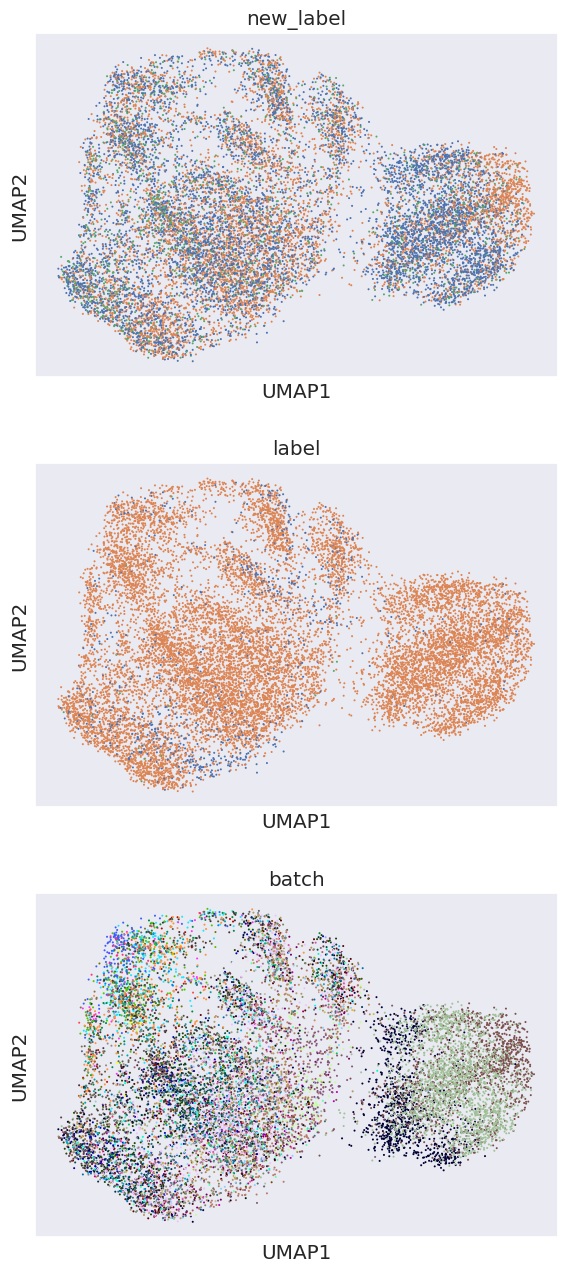

In [167]:
sc.pl.umap(adata, color=["new_label", "label","batch"], ncols=1, legend_loc=None)



In [168]:
adata_copy =adata.copy()

In [170]:
sc.tl.leiden(adata_copy)

running Leiden clustering


KeyError: 'No "neighbors" in .uns'

In [38]:
adjacencies = pd.read_csv("Results/adj_mm_exh.csv", index_col=False)

In [39]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

AEBP2_(+)  ARID3A_(+)  ARID3B_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1          0           0           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1          0           0           0   
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1          0           0           0   
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1          0           0           0   
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1          1           0           0   

                                       ARNT_(+)  ARNTL_(+)  ATF1_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1         0          0         0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1         0          0         0   
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1         0          0         0   
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1         0          0         0   
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1         0          0         0   

                                       ATF2_(+)  ATF4_(+)  ATF6_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1         0         0         0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1         0         1         0   
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1         0         0         0   
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1         0         1         0   
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1         0         0         0   

                                       ATF6B_(+)  ...  ZNF652_(+)  ZNF655_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1          0  ...           0           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1          0  ...           0           0   
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1          0  ...           0           0   
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1          0  ...           0           0   
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1          0  ...           0           0   

                                       ZNF677_(+)  ZNF737_(+)  ZNF75A_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           0           0           0   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0           1           0   
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1           0           0           0   
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1           0           0           1   
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1           0           0           0   

                                       ZNF791_(+)  ZNF836_(+)  ZNF84_(+)  \
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           0           1          1   
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0           1          1   
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1           0           1          1   
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1           0           1          1   
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1           0           1          1   

                                       ZNF891_(+)  ZNF92_(+)  
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1           0          0  
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1           0          0  
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1           0          0  
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1           0          0  
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1           0          0  

[5 rows x 223 columns]

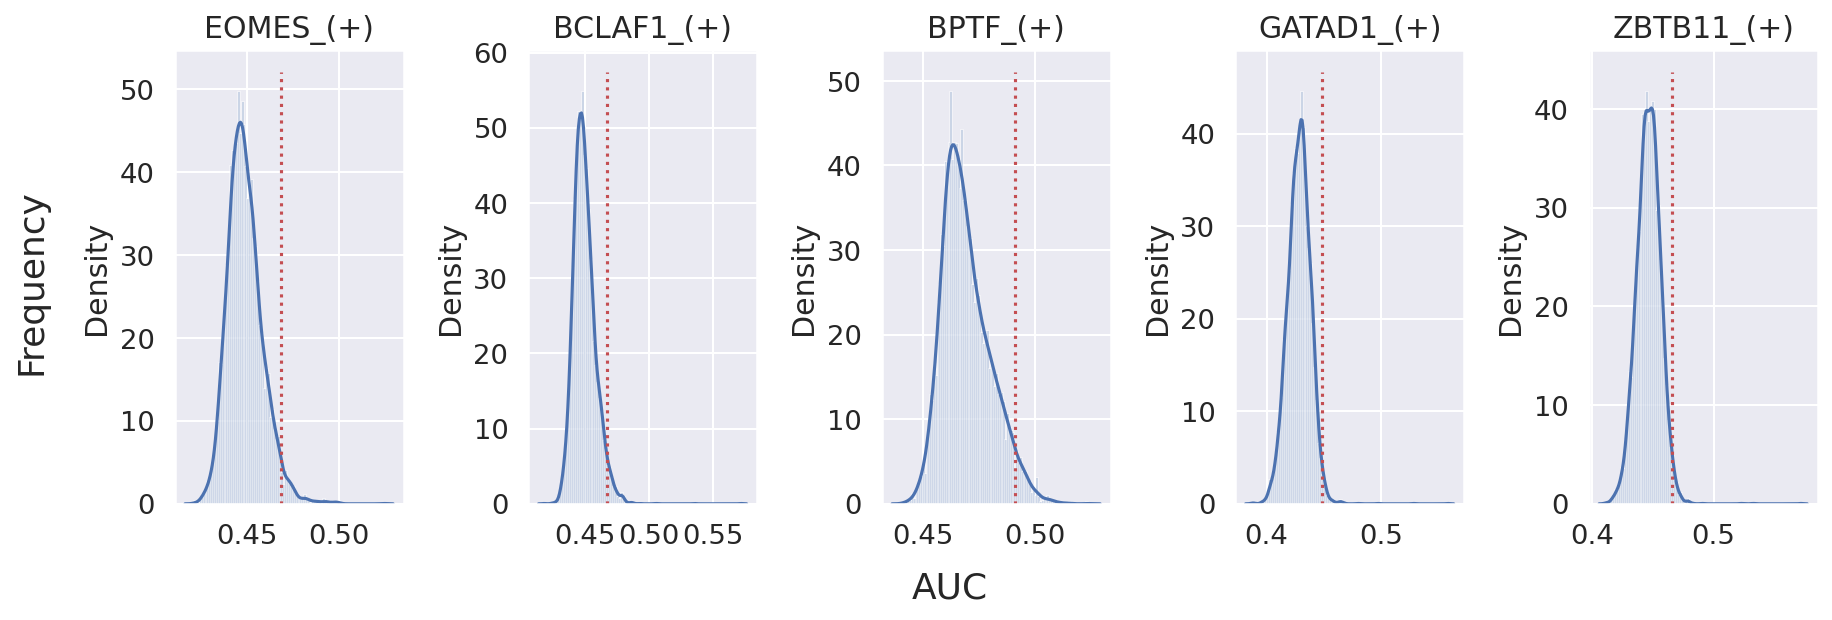

In [41]:
# select regulons:
r = [ 'EOMES_(+)', 'BCLAF1_(+)', 'BPTF_(+)','GATAD1_(+)','ZBTB11_(+)'  ]

fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
#fig.savefig('PBMC10k_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

In [140]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2023-02-23 12:28:13,465 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-02-23 12:28:13,990 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-02-23 12:28:36,107 - pyscenic.utils - INFO - Creating modules.


In [141]:
tf = 'IRF2'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

IRF2 module 0: 1450 genes
IRF2 module 1: 389 genes
IRF2 module 2: 51 genes
IRF2 module 3: 34 genes
IRF2 module 4: 651 genes
IRF2 regulon: 859 genes


In [160]:
[x.transcription_factor for x in modules if x.transcription_factor=="IRF2"]

['IRF2', 'IRF2', 'IRF2', 'IRF2', 'IRF2']

In [142]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'_(+)']:
        f.write("%s\n" % item)

In [65]:
with open("Results/regulons_mm_exh.json", "w") as outfile:
    json.dump(regulons, outfile)